## Traffic flow - Revisited

Cars obey typical conservatook law,

$$
\begin{equation}
\frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial x} = 0
\end{equation}
$$
where $F$ is the flux, and $F=\rho u$. But, from our experience we know that the traffic speed is a function of traffic density. The following aprroximation makes a linear relation between the two.

$$
F(\rho) = \rho \, u_{max}\left(1 - \frac{\rho}{\rho_{max}} \right)
$$

This flux model meet two requirements:
1. $u \rightarrow u_{max}$ and $F\rightarrow 0$ when $\rho \rightarrow 0$,
2. $u \rightarrow 0$ as $\rho \rightarrow \rho_{max}$.

This leads to some unrealistic or at least improbable results. For example, the maximum flux occurs at the maximum flux $\rho^*$, corresponding to a traffic speed of $u_{max}/2$.

We do not expect the maximum flux to increase if we allow arbitrarily high speeds, but there should be some ideal traffic speed $u^*$ corresponding to an ideal traffic density $\rho^*$, resulting in the maximum traffic flux:
$$
F_{\rm max} = \rho^{\star}u^{\star}.
$$

Modifying the introduces flux model by taking this into account, we get,
$$
F(\rho) = u_{\rm max}\rho (1 - A\rho - B \rho^2)
$$
For this model, $F\rightarrow 0$ when $\rho \rightarrow 0$. Let's impose following conditions:
1. When $\rho = \rho_{\rm max}$ traffic flux goes to zero:
$$
F(\rho_{\rm max}) = 0 = u_{\rm max}\, \rho_{\rm max}(1 - A \rho_{\rm max} - B \rho_{\rm max}^2)
$$
2. maximum flux occurs when $\rho = \rho^{\star}$ and $F'(\rho^{\star}) = 0$:
$$
F'(\rho^{\star}) = 0  = u_{\rm max}(1 - 2A\rho^{\star} - 3B(\rho^{\star})^2)
$$
3. $u^{\star}$ is obtained when $\rho = \rho^{\star}$:
$$
u^{\star} = u_{\rm max}(1 - A \rho^{\star} - B(\rho^{\star})^2)
$$

We have three equations and four unknowns $A,B,\rho^{\star}, u^{\star}$

### Solving New Flux Equations with SymPy

In [1]:
import sympy
sympy.init_printing()

(u_max, u_star, rho_max,
 rho_star, A, B) = sympy.symbols('u_max u_star rho_max rho_star A B')

In [2]:
eq1 = sympy.Eq(0, u_max * rho_max * (1 - A * rho_max - B * rho_max**2))
eq2 = sympy.Eq(0, u_max * (1 - 2 * A * rho_star - 3 * B * rho_star**2))
eq3 = sympy.Eq(u_star, u_max * (1 - A * rho_star - B * rho_star**2))

In [3]:
eq1

In [4]:
eq2

In [5]:
eq3

In [6]:
eq4 = sympy.Eq(eq2.lhs - 3 * eq3.lhs, eq2.rhs - 3 * eq3.rhs)
eq4

In [7]:
eq4.simplify()

In [8]:
eq4.expand()

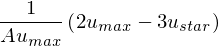

In [9]:
rho_sol = sympy.solve(eq4, rho_star)[0]
rho_sol

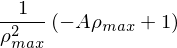

In [10]:
B_sol = sympy.solve(eq1, B)[0]
B_sol

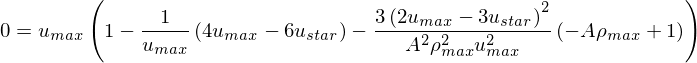

In [11]:
quadA = eq2.subs([(rho_star, rho_sol), (B, B_sol)])
quadA

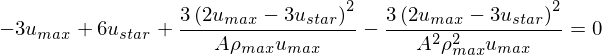

In [12]:
quadA.simplify()

In [13]:
A_sol = sympy.solve(quadA, A)

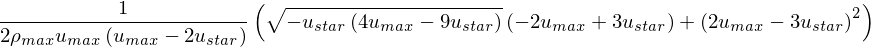

In [14]:
A_sol[0]

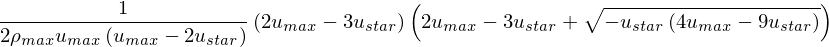

In [15]:
A_sol[1]

### Evaluating the New Flux Equation

Let's numerically evaluate the solutions for A using the following values:
$$
\begin{align} 
\rho_{\rm max} &=10.0 \nonumber\\ u_{\rm max} &=1.0 \nonumber\\ u^{\star} &=0.7 \nonumber
\end{align}
$$

In [16]:
A_val_0 = A_sol[0].evalf(subs={u_star: 0.7, u_max: 1.0, rho_max: 10.0})
A_val_0

In [17]:
A_val_1 = A_sol[1].evalf(subs={u_star: 0.7, u_max: 1.0, rho_max: 10.0})
A_val_1

In [18]:
A_val = max(A_val_0, A_val_1)
A_val

In [19]:
B_val = B_sol.evalf(subs={rho_max: 10.0, A: A_val})
B_val

In [20]:
sympy.init_printing(use_latex=False)

In [21]:
print(type(rho_max), type(u_max))

<class 'sympy.core.symbol.Symbol'> <class 'sympy.core.symbol.Symbol'>


In [22]:
rho_max = 10.0
u_max = 1.0

In [23]:
def flux(rho, u_max, A, B):
    """
    Computes the traffic flux for the better model.
    
    Parameters
    ----------
    rho : numpy.ndarray
       Traffic density along the road as a 1D array of floats
    u_max : float
        Maximum speed allowed on the road
    A : float
        Scaling coefficient for rho
    B : float
        Scaling coefficient for rho squared
    
    Returns
    -------
    F : numpy.ndarray
        The traffic flux along the road as a 1D array of floats.
    """
    F = rho * u_max * (1.0 - A * rho - B * rho**2)
    return F

In [24]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [25]:
# set the font family and size to use for Matplotlib figures
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [26]:
def rho_green_light(x, rho_light):
    """
    Computes the "green light" initial condition. It consists of a 
    shock with a linear distribution behind it.
    
    Parameters
    ----------
    x : numpy.ndarray
        Locations on the road as a 1D array of floats
    rho_light : float
        Car density at the stoplight
    
    Returns
    -------
    rho : numpy.ndarray
        The initial car density along the road as a 1D array of floats
    """
    
    rho = numpy.zeros_like(x)
    mask = numpy.where(x < 2.0)
    rho[mask] = rho_light * x[mask] / 2.0
    
    return rho

In [27]:
# set parameters
nx = 81  # number of locations on the road
L = 4.0  # length of the road
dx = L / (nx - 1)  # distance between two consecutive locations
nt = 30  # number of time steps to compute
rho_light = 5.0  # car density at the traffic light.

# define the locations on the road
x = numpy.linspace(0.0, L, num=nx)

# compute the initial traffic density
rho0 = rho_green_light(x, rho_light)

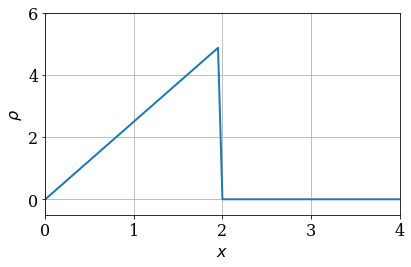

In [28]:
# plot the initial car density on the road
fig = pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$\rho$')
pyplot.grid()
line = pyplot.plot(x, rho0, color='C0', linestyle='-', linewidth=2)[0]
pyplot.xlim(0.0, L)
pyplot.ylim(-0.5, 6.0)
pyplot.tight_layout();

In [29]:
def ftbs(rho0, nt, dt, dx, bc_value, *args):
    """
    Computes the traffic density on the road at a certain time given 
    the initial traffic density.
    
    Parameters
    ----------
    rho0 : numpy.ndarray
        The initial car density along the road as a 1D array of floats
    nt : integer
        The number of time steps to compute
    dt : float
        The time-step size to integrate
    dx : float
        The distance between two consecutive locations
    bc_value : float
        The constant density at the first station.
    args : list or tuple
        Positional arguments to be passed to the flux function
    
    Returns
    -------
    rho_hist : list of numpy.ndarray objects
        The history of the car density along the road
    """
    
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        # compute the flux
        F = flux(rho, *args)
        
        # advance in time
        rho[1:] = rho[1:] - dt / dx * (F[1:] - F[:-1])
        
        # set the left boundary condition
        rho[0] = bc_value
        
        # record the time-step solution
        rho_hist.append(rho.copy())
        
    return rho_hist

In [30]:
# set time-step size based on CFL limit
sigma = 1.0
dt = sigma * dx / u_max  # time-step size

# compute the traffic density at all time steps
rho_hist = ftbs(rho0, nt, dt, dx, rho0[0], u_max, A_val, B_val)

In [31]:
from matplotlib import animation
from IPython.display import HTML

In [32]:
def update_plot(n, rho_hist):
    """
    Update the line y-data of the Matplotlib figure
    
    Parameters
    ----------
    n : integer
        The time-step index
    rho_hist : list of numpy.ndarray objects
        The history of the numerical solution
    """

    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(rho_hist[n])

In [33]:
# create an animation of the traffic density
anim = animation.FuncAnimation(
    fig, update_plot, frames=nt, fargs=(rho_hist,), interval=100)
# display the video
HTML(anim.to_html5_video())